# Install pyspark

In [1420]:
# !pip install pyspark

# Import libraries

In [1421]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [1422]:
spark = SparkSession.builder.appName("Steam").getOrCreate()
spark

### Define Shape() function for further use

In [1423]:
def sparkShape(dataFrame):
    return (dataFrame.count(), len(dataFrame.columns))
pyspark.sql.dataframe.DataFrame.shape = sparkShape

# Read files

In [1424]:
df_leak = spark.read.csv("clean_leak.csv", header=True, inferSchema=True).drop("Title")
df_time = spark.read.csv("leak_time_result.csv", header = True, inferSchema=True)
df_reviews = spark.read.csv("reviews_2018_all.csv", header = True, inferSchema=True).drop("review_score_desc")

# Correct data types

In [1425]:
df_leak = df_leak.withColumn("Players Estimate", col("Players Estimate").cast(IntegerType()))
df_leak = df_leak.withColumnRenamed("Players Estimate","Players")
df_time = df_time.withColumn("year", col("year").cast(IntegerType()))

In [1426]:
df_reviews = df_reviews.withColumnRenamed("app_id","id")
df_leak = df_leak.withColumnRenamed("Steam App ID", "id")

In [1427]:
df_reviews.printSchema()

root
 |-- id: integer (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- total_positive: integer (nullable = true)
 |-- total_negative: integer (nullable = true)
 |-- total_reviews: integer (nullable = true)



In [1428]:
df_leak.printSchema()

root
 |-- Players: integer (nullable = true)
 |-- id: integer (nullable = true)



In [1429]:
df_time.printSchema()

root
 |-- id: integer (nullable = true)
 |-- year: integer (nullable = true)



# Handle missing values

In [1430]:
# Before
df_time.shape()

(12408, 2)

In [1431]:
df_time = df_time.na.drop()

In [1432]:
# After
df_time.shape()

(12381, 2)

In [1433]:
#Before
df_reviews.shape()

(13275, 5)

In [1434]:
df_reviews = df_reviews.filter((df_reviews["total_reviews"] != 0) & \
                               (df_reviews["total_positive"] != 0) & \
                               (df_reviews["total_negative"] != 0) & \
                               (df_reviews["review_score"] != 0) \
                               ).select(df_reviews.columns)

In [1435]:
df_reviews.shape()

(9974, 5)

# Join three frames into one General

In [1436]:
df_general = df_time.join(df_reviews, ["id"]) \
                    .join(df_leak, ["id"])

In [1437]:
df_general.shape()

(9370, 7)

In [1438]:
df_general.show()

+----+----+------------+--------------+--------------+-------------+--------+
|  id|year|review_score|total_positive|total_negative|total_reviews| Players|
+----+----+------------+--------------+--------------+-------------+--------+
| 220|2004|           9|         54855|          1761|        56616| 8877286|
| 240|2004|           9|         65877|          2798|        68675|15001876|
| 240|2004|           9|         65877|          2798|        68675|15001876|
| 300|2010|           8|          9014|           937|         9951| 4419447|
| 380|2006|           8|          6168|           352|         6520| 3917529|
| 400|2007|           9|         43124|           794|        43918| 9971481|
| 420|2007|           9|         11237|           495|        11732| 3281382|
| 440|2007|           8|        446494|         28380|       474874|50191347|
| 440|2007|           8|        446494|         28380|       474874|50191347|
| 500|2008|           9|         14637|           731|        15

In [1439]:
# df_general.write.csv("df_general.csv",header=True)

# Groupby year, count each year number, split

In [1440]:
df_general.groupBy("Year").count().sort("year").show()

+----+-----+
|Year|count|
+----+-----+
|1997|    1|
|2004|    3|
|2006|    6|
|2007|    6|
|2008|   30|
|2009|   49|
|2010|  104|
|2011|  135|
|2012|  208|
|2013|  312|
|2014|  893|
|2015| 1555|
|2016| 2263|
|2017| 2476|
|2018| 1141|
|2019|   87|
|2020|   55|
|2021|   25|
|2022|   21|
+----+-----+



In [1441]:
y2013 = df_general.filter("year <= 2013").select(df_general.columns)  #includes years no more than 2013
y2014 = df_general.filter("year == 2014").select(df_general.columns)
y2015 = df_general.filter("year == 2015").select(df_general.columns)
y2016 = df_general.filter("year == 2016").select(df_general.columns)
y2017 = df_general.filter("year == 2017").select(df_general.columns)
y2018 = df_general.filter("year == 2018").select(df_general.columns)
y2019 = df_general.filter("year >= 2019").select(df_general.columns) # includes years older than 2019

# Boxplot and Describe to filter outliers

## 2013

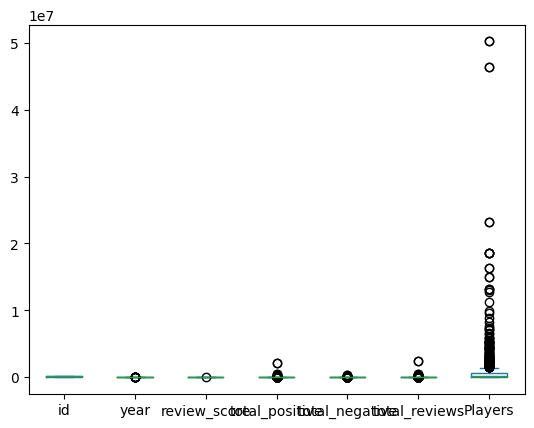

In [1442]:
y2013.toPandas().plot.box();

In [1443]:
y2013.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               id|              year|      review_score|    total_positive|    total_negative|     total_reviews|           Players|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              854|               854|               854|               854|               854|               854|               854|
|   mean|149080.3161592506|2011.5281030444964| 6.913348946135831|13468.991803278688|1454.9309133489462|14923.922716627634|         1134183.5|
| stddev| 92067.8455250179|1.6692605740064466|1.4954357373572178|109852.84337430519|13758.579972057702|123382.35688446091|4083629.7157909987|
|    min|              220|              1997|                 1|                 1|                 1|                11|              1938|
|    m

In [1444]:
y2013 = y2013.filter((y2013["Players"] <= 10000000))

In [1445]:
y2013.shape()

(835, 7)

## 2014

+-------+------------------+------+------------------+-----------------+------------------+-----------------+------------------+
|summary|                id|  year|      review_score|   total_positive|    total_negative|    total_reviews|           Players|
+-------+------------------+------+------------------+-----------------+------------------+-----------------+------------------+
|  count|               893|   893|               893|              893|               893|              893|               893|
|   mean|  283194.882418813|2014.0| 6.399776035834266| 1818.01679731243|349.24860022396416|2167.265397536394|211513.78723404257|
| stddev|33858.786913405296|   0.0|1.5359226040878313|5657.770841744972|1017.3670321171992|6311.847671049619| 590873.4634842963|
|    min|              9940|  2014|                 2|                2|                 1|               13|               563|
|    max|            339510|  2014|                 9|            74283|             13312|      

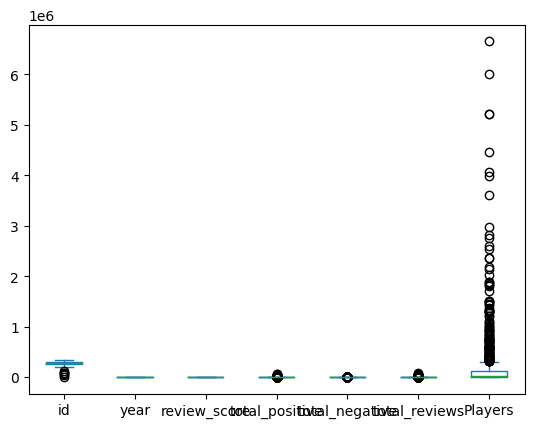

In [1446]:
y2014.toPandas().plot.box();
y2014.describe().show()

In [1447]:
y2014 = y2014.filter((y2014["Players"] <= 1000000))
y2014.shape()

(849, 7)

## 2015

+-------+-----------------+------+------------------+------------------+------------------+------------------+------------------+
|summary|               id|  year|      review_score|    total_positive|    total_negative|     total_reviews|           Players|
+-------+-----------------+------+------------------+------------------+------------------+------------------+------------------+
|  count|             1555|  1555|              1555|              1555|              1555|              1555|              1555|
|   mean|351745.7189710611|2015.0| 6.400643086816721|1620.9581993569132| 360.1710610932476|1981.1292604501607|154882.17491961416|
| stddev|42991.70863785752|   0.0|1.4117997306105818|10449.208997061665|3185.8059205253953|13102.498416664648| 676385.6108747692|
|    min|           200150|  2015|                 2|                 1|                 1|                10|                83|
|    max|           691630|  2015|                 9|            254544|            108090

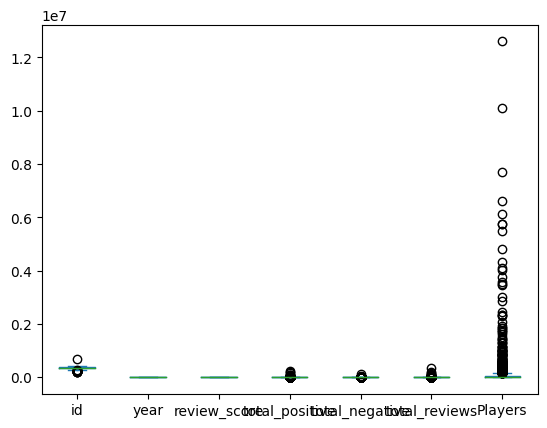

In [1448]:
y2015.toPandas().plot.box();
y2015.describe().show()

In [1449]:
y2015 = y2015.filter((y2015["Players"] <= 3000000))
y2015.shape()

(1538, 7)

## 2016

+-------+------------------+------+------------------+-----------------+------------------+------------------+------------------+
|summary|                id|  year|      review_score|   total_positive|    total_negative|     total_reviews|           Players|
+-------+------------------+------+------------------+-----------------+------------------+------------------+------------------+
|  count|              2263|  2263|              2263|             2263|              2263|              2263|              2263|
|   mean|447023.09765797615|2016.0| 6.468404772425983|843.3261157755193|183.29650905877153|1026.6226248342907| 83342.98055678303|
| stddev|  71476.9255687775|   0.0|1.3458997137404816|4588.994731147149|1280.7962208512251| 5532.605597500122|334688.03913678095|
|    min|             40980|  2016|                 1|                2|                 1|                10|                95|
|    max|            575010|  2016|                 9|            95679|             41797

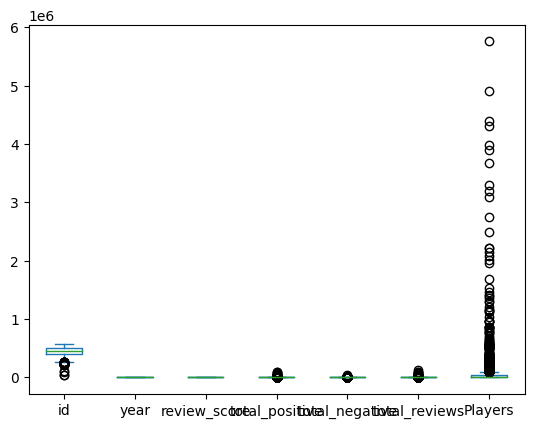

In [1450]:
y2016.toPandas().plot.box();
y2016.describe().show()

In [1451]:
y2016 = y2016.filter((y2016["Players"] <= 2000000))
y2016.shape()

(2246, 7)

## 2017

+-------+-----------------+------+------------------+------------------+------------------+------------------+------------------+
|summary|               id|  year|      review_score|    total_positive|    total_negative|     total_reviews|           Players|
+-------+-----------------+------+------------------+------------------+------------------+------------------+------------------+
|  count|             2476|  2476|              2476|              2476|              2476|              2476|              2476|
|   mean|588541.8982229403|2017.0| 6.453957996768982| 1096.760096930533| 464.7794830371567|1561.5395799676899|112301.23909531502|
| stddev|107931.5792188646|   0.0|1.2992229552805579|13758.671589939098|10668.693723824226|23621.294013657352| 1350100.220223516|
|    min|           227860|  2017|                 2|                 1|                 1|                10|                54|
|    max|           770400|  2017|                 9|            394617|            372037

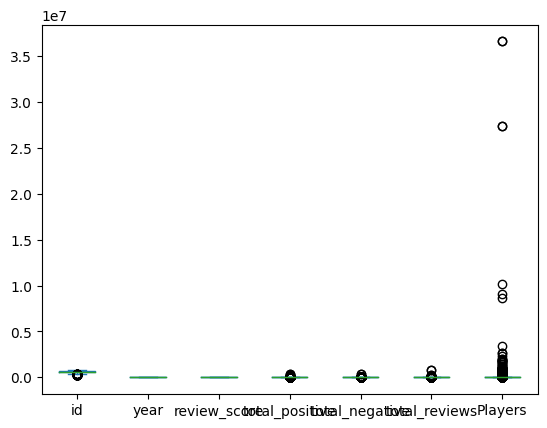

In [1452]:
y2017.toPandas().plot.box();
y2017.describe().show()

In [1453]:
y2017 = y2017.filter((y2017["Players"] <= 5000000))
y2017.shape()

(2469, 7)

## 2018

+-------+------------------+------+-----------------+-----------------+------------------+------------------+-----------------+
|summary|                id|  year|     review_score|   total_positive|    total_negative|     total_reviews|          Players|
+-------+------------------+------+-----------------+-----------------+------------------+------------------+-----------------+
|  count|              1141|  1141|             1141|             1141|              1141|              1141|             1141|
|   mean|  687489.736196319|2018.0|6.530236634531113|862.7563540753724|170.24014022787028|1032.9964943032428|70571.21647677476|
| stddev|142764.83949614232|   0.0|1.245415042532211|8516.604276058062|1628.2467344499723|10068.593485894551|708332.2364926941|
|    min|            206500|  2018|                3|                2|                 1|                10|               34|
|    max|            882560|  2018|                9|           180850|             40762|            22

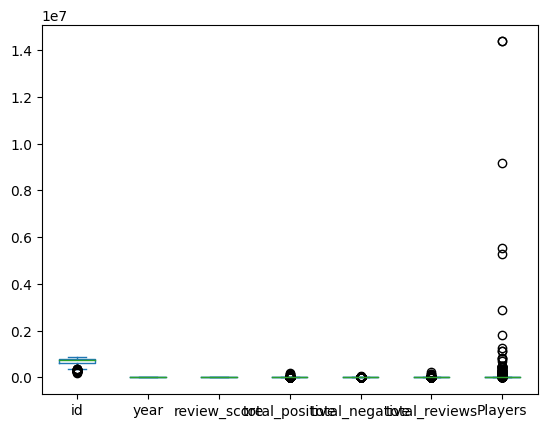

In [1454]:
y2018.toPandas().plot.box();
y2018.describe().show()

In [1455]:
y2018 = y2018.filter((y2018["Players"] <= 2000000))
y2018.shape()

(1135, 7)

## 2019

+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|                id|              year|      review_score|    total_positive|    total_negative|    total_reviews|           Players|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|               188|               188|               188|               188|               188|              188|               188|
|   mean| 542162.2872340425|2019.8936170212767| 6.781914893617022|1722.5212765957447| 383.6595744680851| 2106.18085106383|179712.50531914894|
| stddev|154367.52137058767|1.0182094497493963|1.3285400910273033|  5501.76024088727|1285.5969175028647|6412.073678211948| 581939.6253235523|
|    min|            227780|              2019|                 4|                 5|                 1|               11|               122|
|    m

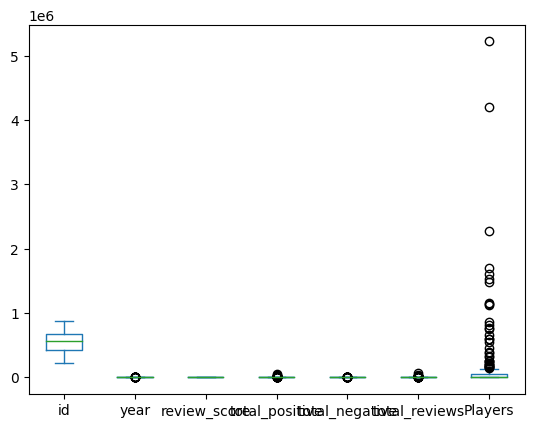

In [1456]:
y2019.toPandas().plot.box();
y2019.describe().show()

In [1457]:
y2019 = y2019.filter((y2019["Players"] <= 1000000))
y2019.shape()

(178, 7)

In [1458]:
year_group = [y2013,y2014,y2015,y2016,y2017,y2018,y2019]
year_strings = [f"year 201{i}" for i in range(3,10)]

In [1459]:
# [year_group[i].write.csv(f"{year_strings[i]}.csv",header=True) for i in range(7)]

# Regression based on different years 

## Linear Regression: Single Variable, take 2018 as example

In [1460]:
linear_featureassebler = VectorAssembler(inputCols=["total_reviews"],outputCol="Features")

In [1461]:
output2018 = linear_featureassebler.transform(y2018)

In [1462]:
final2018 = output2018.select("Features", "Players")

In [1463]:
final2018.show()

+---------+-------+
| Features|Players|
+---------+-------+
| [7997.0]|1823483|
| [3288.0]| 169523|
| [1869.0]| 126220|
|  [330.0]|  20480|
|   [94.0]|   2262|
|   [89.0]|   5953|
| [3964.0]| 489971|
|   [35.0]|   1515|
|  [445.0]|  17993|
| [4384.0]| 295630|
|  [281.0]|  14040|
|[21629.0]|1123426|
|  [202.0]|   9691|
| [5324.0]| 436655|
|  [484.0]|  29603|
|   [31.0]|   1397|
|   [16.0]|    465|
| [2408.0]| 166057|
| [1758.0]| 103699|
| [2654.0]| 146235|
+---------+-------+
only showing top 20 rows



### train test split

In [1464]:
train, test = final2018.randomSplit([0.75,0.25],seed="964")

### set and fit regressor

In [1465]:
regressor = LinearRegression(featuresCol="Features", labelCol="Players")
regressor = regressor.fit(train)

### Coefficients and intercept

In [1466]:
regressor.coefficients

DenseVector([54.904])

In [1467]:
regressor.intercept

4496.446033325678

### Prediction

In [1468]:
pred_result = regressor.evaluate(test)

In [1469]:
pred_result.predictions.sort(col("Players").desc()).show()

+---------+-------+------------------+
| Features|Players|        prediction|
+---------+-------+------------------+
|[12595.0]| 679334| 696012.3561504263|
| [2049.0]| 420843|116994.74693288417|
| [1192.0]| 257046| 69942.01688363009|
| [1115.0]| 238249| 65714.40869950807|
|   [80.0]| 152900| 8888.766224621275|
|  [677.0]| 144867|41666.455652164674|
| [1282.0]| 101445| 74883.37709883762|
| [1668.0]|  99719| 96076.32202183889|
|  [832.0]|  95199|  50176.5760227999|
| [2308.0]|  93498|131214.88355220368|
|  [528.0]|  76904|33485.759295876625|
|  [452.0]|  76897|29313.055114145805|
|  [428.0]|  75371|27995.359056757126|
| [2861.0]|  69416| 161576.7968745345|
|   [20.0]|  65550| 5594.526081149577|
| [1496.0]|  58680| 86632.83361055335|
|  [207.0]|  53571|15861.574528303037|
|  [540.0]|  52272| 34144.60732457096|
|   [11.0]|  50306| 5100.390059628823|
|   [40.0]|  50010| 6692.606128973477|
+---------+-------+------------------+
only showing top 20 rows



In [1470]:
pred_result.r2

0.72550742453599

## Linear regression: single variable, all years, same logic

In [1471]:
linear_featureassebler = VectorAssembler(inputCols=["total_reviews"],outputCol="Features")
output_years = [linear_featureassebler.transform(year) for year in year_group]
final_years = [output.select("Features", "Players") for output in output_years]

train_groups = []
test_groups = []
for final_year in final_years:
    train,test = final_year.randomSplit([0.75,0.25],seed="964")
    train_groups.append(train)
    test_groups.append(test)

regressor = LinearRegression(featuresCol="Features", labelCol="Players")
regressors = [regressor.fit(train) for train in train_groups]
coefficients = [regressor.coefficients.values[0] for regressor in regressors]

print("Coefficients:")
print(list(zip(year_strings, coefficients)))

pred_results = [regressors[i].evaluate(test_groups[i]) for i in range(7)]
R2s = [pred_result.r2 for pred_result in pred_results]
print("\n")
print("R2s:")
print(list(zip(year_strings,R2s)))

Coefficients:
[('year 2013', 109.29148716914929), ('year 2014', 72.0848560601924), ('year 2015', 70.92136022928503), ('year 2016', 40.12642375447233), ('year 2017', 73.37328688381068), ('year 2018', 54.90400239119497), ('year 2019', 50.683854904318444)]


R2s:
[('year 2013', 0.664410961790715), ('year 2014', 0.5942971871791998), ('year 2015', 0.6676766649606283), ('year 2016', 0.6911286926252946), ('year 2017', 0.661477810352908), ('year 2018', 0.72550742453599), ('year 2019', 0.5964575126785103)]


## Multi-variable regression: Linear, Decision Tree, Random Forest (2018)

In [1472]:
featureassebler2 = VectorAssembler(inputCols=["review_score","total_positive","total_negative"], outputCol="Features")
output2018 = featureassebler2.transform(y2018)
final2018 = output2018.select("Features", "Players")
train, test = final2018.randomSplit([0.75,0.25],seed="964")

#### linear

In [1473]:
regressor = LinearRegression(featuresCol="Features", labelCol="Players")
regressor = regressor.fit(train)
pred_result = regressor.evaluate(test)
pred_result.predictions.sort(col("Players").desc()).show()
pred_result.r2, pred_result.r2adj

+--------------------+-------+------------------+
|            Features|Players|        prediction|
+--------------------+-------+------------------+
|[6.0,15438.0,6596.0]|1140205|1333492.6146236747|
|[6.0,19839.0,5990.0]| 827988|1618923.7399582854|
|  [5.0,1260.0,789.0]| 455442|120794.21639786272|
| [5.0,5162.0,2702.0]| 348944|466548.35534133605|
| [4.0,1515.0,2692.0]| 248224|210980.48047253853|
| [5.0,2258.0,1570.0]| 224856| 220261.2082245579|
|  [6.0,2680.0,759.0]| 191656|218815.29245863095|
|     [5.0,49.0,31.0]| 187222| 7273.489101882218|
|  [6.0,2618.0,907.0]| 162765|220069.62852307028|
|  [6.0,1041.0,277.0]| 119509| 85747.08447030945|
|  [5.0,1327.0,710.0]| 118244|122500.23884134249|
|  [8.0,1441.0,157.0]| 113593|108562.15826591305|
|  [8.0,1211.0,186.0]| 110374| 93544.28522080905|
|   [5.0,929.0,829.0]| 103699| 99115.91729509592|
|   [4.0,156.0,272.0]|  75371|24222.382181557456|
|   [8.0,789.0,128.0]|  73841| 61783.10544810767|
|      [4.0,5.0,15.0]|  65550| 3921.198684632332|


(0.6611116025433404, 0.6577562718754527)

#### Decision Tree

In [1474]:
regressor = DecisionTreeRegressor(featuresCol="Features", labelCol="Players")
model = regressor.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(
    labelCol="Players", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data = %g" % r2)

R2 on test data = 0.606234


### Random Forest

In [1475]:
regressor = RandomForestRegressor(featuresCol="Features", labelCol="Players")
model = regressor.fit(train)
predictions = model.transform(test)
evaluator = RegressionEvaluator(
    labelCol="Players", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R2 on test data = %g" % r2)

R2 on test data = 0.608469


## Multi-variable regression: all years

In [1476]:
featureassebler2 = VectorAssembler(inputCols=["review_score","total_positive","total_negative"], outputCol="Features")
output_years = [featureassebler2.transform(year) for year in year_group]
final_years = [output.select("Features", "Players") for output in output_years]

train_groups = []
test_groups = []
for final_year in final_years:
    train,test = final_year.randomSplit([0.75,0.25],seed="964")
    train_groups.append(train)
    test_groups.append(test)

### Linear

In [1477]:
regressor = LinearRegression(featuresCol="Features", labelCol="Players")
regressors = [regressor.fit(train) for train in train_groups]

pred_results = [regressors[i].evaluate(test_groups[i]) for i in range(7)]
R2s = [pred_result.r2 for pred_result in pred_results]
adj_R2s = [pred_result.r2adj for pred_result in pred_results]

coefficients = [regressor.coefficients.values[0] for regressor in regressors]

print("Coefficients:")
print(list(zip(year_strings, coefficients)))
print("\n")

print("R2s:")
print(list(zip(year_strings,R2s)))
print("\n")

print("Adj_R2s")
print(list(zip(year_strings,adj_R2s)))


Coefficients:
[('year 2013', 15745.788939362661), ('year 2014', 6165.100724077476), ('year 2015', -1056.7047692684002), ('year 2016', -9778.058677165163), ('year 2017', 45.69440254808987), ('year 2018', -335.7751142252602), ('year 2019', -1950.5694357062514)]


R2s:
[('year 2013', 0.49050409631579917), ('year 2014', 0.682751380452213), ('year 2015', 0.6342010240608202), ('year 2016', 0.5762976284657665), ('year 2017', 0.6562504141956333), ('year 2018', 0.6611116025433404), ('year 2019', 0.5194780969501094)]


Adj_R2s
[('year 2013', 0.48388726639782254), ('year 2014', 0.6787013980750072), ('year 2015', 0.6314711809567966), ('year 2016', 0.5741861548534697), ('year 2017', 0.6547066286306437), ('year 2018', 0.6577562718754527), ('year 2019', 0.48813971196859474)]


### Decision Tree

In [1478]:
regressor = DecisionTreeRegressor(featuresCol="Features", labelCol="Players")
models = [regressor.fit(train) for train in train_groups]
predictions = [models[i].transform(test_groups[i]) for i in range(7)]

evaluator = RegressionEvaluator(
    labelCol="Players", predictionCol="prediction", metricName="r2")
r2s = [evaluator.evaluate(prediction) for prediction in predictions]

print("R2s:")
print(list(zip(year_strings,r2s)))
print("\n")

R2s:
[('year 2013', 0.7041011631388011), ('year 2014', 0.7474767438867173), ('year 2015', 0.6710705753071112), ('year 2016', 0.6739008037003021), ('year 2017', 0.621182860992976), ('year 2018', 0.6062344616916902), ('year 2019', 0.6151615236376766)]




### Random Forest

In [1479]:
regressor = RandomForestRegressor(featuresCol="Features", labelCol="Players")
models = [regressor.fit(train) for train in train_groups]
predictions = [models[i].transform(test_groups[i]) for i in range(7)]
evaluator = RegressionEvaluator(
    labelCol="Players", predictionCol="prediction", metricName="r2")
r2s = [evaluator.evaluate(prediction) for prediction in predictions]

print("R2s:")
print(list(zip(year_strings,r2s)))
print("\n")

R2s:
[('year 2013', 0.751201185549208), ('year 2014', 0.7503661883438872), ('year 2015', 0.6990372750161118), ('year 2016', 0.7306308676520047), ('year 2017', 0.6340922644166836), ('year 2018', 0.608469179014659), ('year 2019', 0.597282167909249)]


